In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['legend.title_fontsize'] = 11
mpl.rcParams['legend.fontsize'] = 11
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11

pd.options.display.float_format = '{:.3f}'.format

Load BLASTp results (identity & evalue).

In [2]:
df = pd.read_table('data/blastp.txt', header=None, sep='\s+')
df.columns = ['Name', 'Identity', 'Evalue']
df = df.drop_duplicates(subset='Name')
df

,Name,Identity,Evalue
0,T1SE-1,25.806,1.100
1,T1SE-2,54.202,0.000
2,T1SE-3,48.974,0.000
3,T1SE-4,32.258,1.300
4,T1SE-5,33.871,0.000
...,...,...,...
142,T6SE-16,60.000,0.000
143,T6SE-17,42.953,0.000
144,T6SE-18,40.940,0.000
145,T6SE-19,31.071,0.000


Divide the effectors into groups according to sequence identity.

In [3]:
df['Identity group'] = '<20%'
df.loc[(df['Identity'] >= 20) & (df['Evalue'] <= 0.01), 'Identity group'] = '20-30%'
df.loc[(df['Identity'] >= 30) & (df['Evalue']<=0.01), 'Identity group'] = '30-40%'
df.loc[(df['Identity'] >= 40) & (df['Evalue']<=0.01), 'Identity group'] = '40-50%'
df.loc[(df['Identity'] >= 50) & (df['Evalue'] <= 0.01), 'Identity group'] = '50-60%'
df.loc[(df['Identity'] >= 60) & (df['Evalue'] <= 0.01), 'Identity group'] = '>=60%'
df = df.reset_index(drop=True)

Define evaluation metrics.

In [4]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score


def one_hot_encoding(y, num_class=6):
    return np.eye(num_class)[y]

def metrics(y, pred, score, index=[1,2,3,4,5]):
    accuracy = accuracy_score(y, pred)
    f1 = f1_score(y, pred, average="macro")
    precision = precision_score(y, pred, average="macro")
    recall = recall_score(y, pred, average="macro")

    y_one_hot = one_hot_encoding(y)
    roc_auc = roc_auc_score(y_one_hot[:, index], score[:, index], average="macro", multi_class='ovr')
    average_precision = average_precision_score(y_one_hot[:, index], score[:, index], average="macro")

    metrics_dict = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1,
                    "AUC": roc_auc, "AUPRC": average_precision}
    return metrics_dict


Display the prediction results for various identity groups by different model architectures.

In [5]:
res = pd.DataFrame({'Model': [], 'Identity Group': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-score': [], 'AUC': [], 'AUPRC': []})

for model_name in ['PSSM-CNN', 'TAPE-Linear', 'ESM1b-Linear', 'ESM1b-Finetune', 'DeepSecE']:
    mode = 'test'

    for idx in range(5):
        y = np.load(f'{model_name}/y_{mode}_{idx+1}.npy')
        pred = np.load(f'{model_name}/pred_{mode}_{idx+1}.npy')
        prob = np.load(f'{model_name}/prob_{mode}_{idx+1}.npy')

        y_ = y[150:]
        pred_ = pred[150:]
        prob_ = prob[150:]

        for identity_range in ['<20%', '20-30%', '30-40%', '40-50%','50-60%', '>=60%']:
            index = df.index[df['Identity group'] == identity_range].tolist()
            if identity_range == '>=60%':
                metrics_dict = metrics(y_[index], pred_[index], prob_[index], index=[1,3,4,5])
            else:
                metrics_dict = metrics(y_[index], pred_[index], prob_[index])
            metrics_dict['Identity Group'] = identity_range
            metrics_dict['Model'] = model_name
            res = res.append(metrics_dict, ignore_index=True)

display(res.groupby(['Model','Identity Group']).agg(['mean', 'std']))


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:

Accuracy       Precision       Recall        \
                                  mean   std      mean   std   mean   std   
Model          Identity Group                                               
DeepSecE       20-30%            0.862 0.034     0.948 0.011  0.880 0.030   
               30-40%            0.933 0.000     0.933 0.000  0.967 0.000   
               40-50%            0.920 0.045     0.733 0.149  0.733 0.149   
               50-60%            1.000 0.000     1.000 0.000  1.000 0.000   
               <20%              0.857 0.020     0.662 0.036  0.546 0.054   
               >=60%             0.957 0.039     0.880 0.110  0.850 0.137   
ESM1b-Finetune 20-30%            0.862 0.034     0.948 0.011  0.880 0.030   
               30-40%            0.867 0.000     0.900 0.000  0.867 0.000   
               40-50%            0.910 0.074     0.750 0.167  0.733 0.160   
               50-60%            0.969 0.042     0.970 0.045  0.980 0.027   
               <20%              0.869 0.016     0.650 0.007  0.542 0.023   
               >=60%             0.971 0.039     0.920 0.110  0.900 0.137   
ESM1b-Linear   20-30%            0.846 0.000     0.943 0.000  0.867 0.000   
               30-40%            0.867 0.000     0.900 0.000  0.867 0.000   
               40-50%            0.730 0.045     0.463 0.102  0.525 0.037   
               50-60%            0.908 0.034     0.880 0.076  0.910 0.089   
               <20%              0.846 0.016     0.642 0.018  0.523 0.025   
               >=60%             0.929 0.000     0.800 0.000  0.750 0.000   
PSSM-CNN       20-30%            0.738 0.042     0.580 0.051  0.645 0.031   
               30-40%            0.667 0.067     0.517 0.116  0.489 0.096   
               40-50%            0.820 0.057     0.690 0.093  0.682 0.092   
               50-60%            0.692 0.109     0.670 0.126  0.547 0.137   
               <20%              0.731 0.016     0.589 0.063  0.489 0.061   
               >=60%             0.900 0.064     0.833 0.094  0.770 0.130   
TAPE-Linear    20-30%            0.815 0.042     0.752 0.107  0.733 0.082   
               30-40%            0.813 0.030     0.760 0.070  0.761 0.087   
               40-50%            0.780 0.045     0.658 0.156  0.688 0.089   
               50-60%            0.877 0.042     0.890 0.055  0.903 0.045   
               <20%              0.846 0.026     0.700 0.080  0.664 0.023   
               >=60%             0.814 0.064     0.589 0.072  0.586 0.110   

                              F1-score         AUC       AUPRC        
                                  mean   std  mean   std  mean   std  
Model          Identity Group                                         
DeepSecE       20-30%            0.898 0.025 0.988 0.007 0.978 0.012  
               30-40%            0.942 0.000 0.996 0.005 0.996 0.005  
               40-50%            0.733 0.149 1.000 0.000 1.000 0.000  
               50-60%            1.000 0.000 1.000 0.000 1.000 0.000  
               <20%              0.576 0.035 0.973 0.005 0.855 0.015  
               >=60%             0.863 0.125 1.000 0.000 1.000 0.000  
ESM1b-Finetune 20-30%            0.898 0.025 0.993 0.005 0.988 0.011  
               30-40%            0.848 0.000 0.993 0.009 0.988 0.019  
               40-50%            0.733 0.169 0.999 0.002 0.993 0.015  
               50-60%            0.970 0.044 1.000 0.000 1.000 0.000  
               <20%              0.583 0.020 0.940 0.026 0.806 0.032  
               >=60%             0.909 0.125 0.993 0.017 0.993 0.017  
ESM1b-Linear   20-30%            0.887 0.000 0.987 0.002 0.976 0.002  
               30-40%            0.848 0.000 0.992 0.008 0.975 0.024  
               40-50%            0.460 0.063 1.000 0.000 1.000 0.000  
               50-60%            0.880 0.078 0.997 0.007 0.980 0.045  
               <20%              0.565 0.030 0.958 0.011 0.809 0.029  
               >=60%             0.771 0.000 0.995 0.007 0.992 0.011

Plot lineplots of accuracy and F1-score.

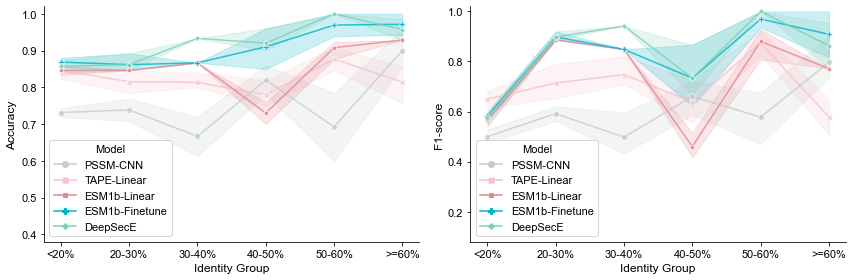

In [6]:
import seaborn as sns

fig, ax =plt.subplots(1,2, figsize=(12, 4))
model_to_color = {
    "PSSM-CNN":"#c6cccc",
    "TAPE-Linear":"#F5C1CB",
    "ESM1b-Linear":"#e38690",
    "ESM1b-Finetune":"#00b3ca",
    "DeepSecE":"#7dd0b6"
}

sns.lineplot(x="Identity Group", y="Accuracy", data=res, hue="Model", style="Model", palette=sns.color_palette(
    model_to_color.values()), ax=ax[0], alpha=0.8, markers=True, dashes=False)
sns.lineplot(x="Identity Group", y="F1-score", data=res, hue="Model", style="Model",
             palette=sns.color_palette(model_to_color.values()), ax=ax[1], alpha=0.8, markers=True, dashes=False)
ax[0].set_ylim(0.38,1.02)
ax[1].set_ylim(0.08,1.02)
sns.despine()
plt.tight_layout()

plt.savefig("pdf/allmodel_identity_comparison.pdf")

plt.show()
